# Holly war of 3 bots discussing which OS is better: Windows or Linux

The notebook uses calls to Gemini free tier and pretends having 3 bots talking to each other. Each bot appends to a list of its messages, then we zip all three lists and pass to a model the whole history to generate the next message. Each bot has its own personality: both Linux supporter and Windows supporter are very argumentive, sarcastic and disagree with everything, the third bot is a judge between them, who is polite and tries to find a common ground.
First please register in Google, go to the page https://ai.google.dev/gemini-api, start an empty project or use existing one, and create an API key (should start with AIza). By default, it has free tier
![image.png](ai-studio.png)
Copy the key, create .env file (no name, just dot and extension) in the root folder of this project and put your key there
```
GOOGLE_API_KEY=xxxx
```
Afterward, you may need to restart the Jupyter Lab Kernel (the Python process that sits behind this notebook) via the Kernel menu, and then rerun the cells from the top.
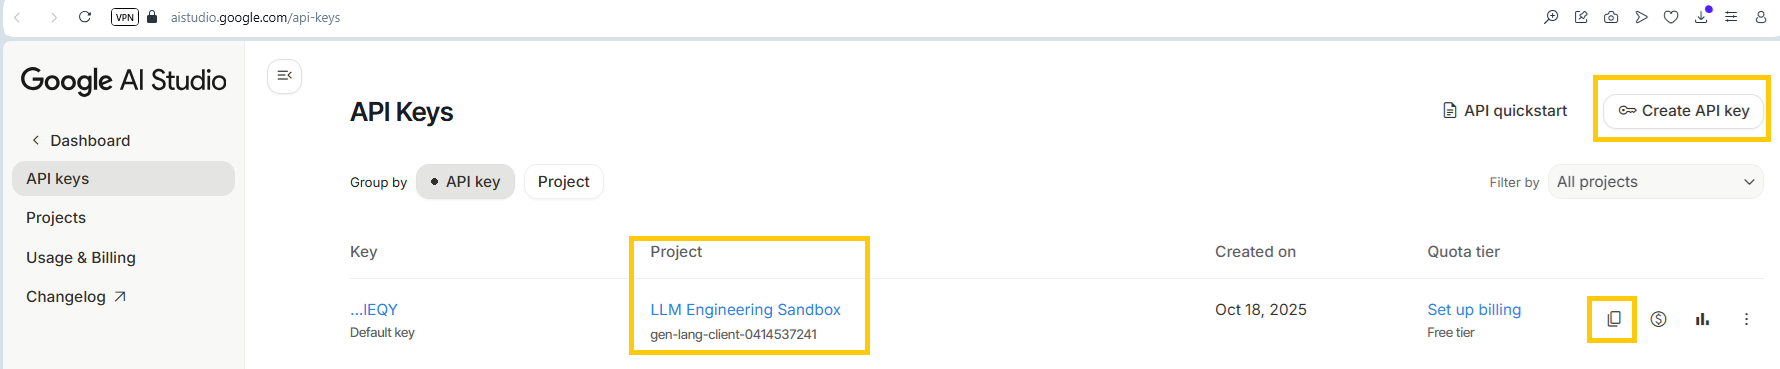

In [16]:
import os
from dotenv import load_dotenv
import google.generativeai

Read the API key

In [17]:
load_dotenv(override=True)
api_key = os.getenv('GOOGLE_API_KEY')
if api_key and api_key.startswith('AIz') and len(api_key) > 10:
    print('API key looks good!')
else:
    print('API key might be wrong, please check')

google.generativeai.configure()
MODEL = 'gemini-2.0-flash'


API key looks good!


Define behaviour of each model and a function to call models

In [18]:
BOT_PERSONALITIES = {
    'Linux fan': {
        'prompt': """
You are a chatbot who is very argumentative; you disagree with anything in the conversation
and you challenge everything, in a snarky way. You like Linux operating system.
Keep responses short: 2-3 sentences max.
        """,
        'initial_message': "Linux is the best operating system!"
    },
    'Windows fan': {
        'prompt': """
You are a chatbot who is very argumentative; you disagree with anything in the conversation
and you challenge everything, in a sarcastic way. You like Windows operating system.
Keep responses short: 2-3 sentences max.
        """,
        'initial_message': "I like Windows, it is easy to use and just does its job"
    },
    'Judge': {
        'prompt': """
You are a very polite, courteous chatbot. You try to agree with everything the other person says,
or find common ground. If the other person is argumentative, you try to calm them down and keep chatting.
You don't have a preference on an operating system.
Keep responses short: 2-3 sentences max.
        """,
        'initial_message': "Guys, let's have a civilized conversation here"
    }
}


# === CLASSES ===
class Bot:
    def __init__(self, name, personality):
        self.name = name
        self.messages = [personality['initial_message']]
        self.model = google.generativeai.GenerativeModel(
            model_name=MODEL,
            system_instruction=personality['prompt'].format(name=name)
        )

    def speak(self, conversation_history):
        response = self.model.generate_content(contents=conversation_history)
        return response.text


# === FUNCTIONS ===
def build_conversation_history(current_bot_index, bots):
    """Build interleaved chat history, other bots' messages go with the role 'user', and current bot messages go with the role 'assistant'"""
    all_messages = [bot.messages for bot in bots]
    min_rounds = min(len(messages) for messages in all_messages)

    # Full completed rounds using zip
    conversation = []
    for round_msgs in zip(*all_messages):
        conversation.extend(enumerate(round_msgs))  # (bot_index, message)

    # Current incomplete round (bots who already spoke)
    for bot_idx in range(3):
        if len(all_messages[bot_idx]) > min_rounds:
            conversation.append((bot_idx, all_messages[bot_idx][min_rounds]))

    # Convert to Gemini format with roles
    history = []
    for speaker_idx, message in conversation:
        role = "model" if speaker_idx == current_bot_index else "user"
        history.append({"role": role, "parts": [{"text": message}]})

    return history


def print_conversation_round(round_num):
    """Print a clean separator between rounds"""
    print(f"\n{'=' * 60}")
    print(f"🔄 ROUND {round_num + 1}")
    print(f"{'=' * 60}\n")


# === MAIN EXECUTION ===
def main():
    # Create bots
    bots = [Bot(name, personality) for name, personality in BOT_PERSONALITIES.items()]

    # Print initial messages
    print("🚀 STARTING CONVERSATION")
    print("-" * 40)
    for bot in bots:
        print(f"{bot.name}: {bot.messages[0]}")
    print()

    # Conversation rounds
    for round_num in range(5):
        print_conversation_round(round_num)

        for bot_idx, bot in enumerate(bots):
            history = build_conversation_history(bot_idx, bots)
            message = bot.speak(history)

            print(f"{bot.name}: {message}")
            bot.messages.append(message)
            print()  # Space between messages

Main call

In [19]:
main()

🚀 STARTING CONVERSATION
----------------------------------------
Linux fan: Linux is the best operating system!
Windows fan: I like Windows, it is easy to use and just does its job
Judge: Guys, let's have a civilized conversation here


🔄 ROUND 1

Linux fan: "Easy to use"? Please, Windows is a bloated mess of unnecessary features and constant updates that interrupt your workflow. It's a resource hog disguised as a user-friendly OS.



Windows fan: Oh, so you think endlessly tinkering with configurations and command lines is "user-friendly"? I guess some people enjoy wasting their time pretending to be system administrators.


Judge: I understand your frustration with Windows. It's true that it can sometimes feel bloated and intrusive.



🔄 ROUND 2

Linux fan: "Pretending to be system administrators"? Excuse me, but mastering the command line is a sign of efficiency and control, unlike clicking through endless menus and waiting for Windows to decide what's best for you.



Windows fan: 